# 01. Neural Network Regression with TensorFlow

There are many definitions for a [regression problem](https://en.wikipedia.org/wiki/Regression_analysis) but in our case, we're going to simplify it to be: predicting a number.

For example, you might want to:
- Predict the selling price of houses given information about them (such as number of rooms, size, number of bathrooms).
- Predict the coordinates of a bounding box of an item in an image.
- Predict the cost of medical insurance for an individual given their demographics (age, sex, gender, race).

In this notebook, we're going to set the foundations for how you can take a sample of inputs (this is your data), build a neural network to discover patterns in those inputs and then make a prediction (in the form of a number) based on those inputs.

## What we're going to cover

Specifically, we're going to go through doing the following with TensorFlow:
- Architecture of a regression model
- Input shapes and output shapes
  - `X`: features/data (inputs)
  - `y`: labels (outputs)
- Creating custom data to view and fit
- Steps in modelling
  - Creating a model
  - Compiling a model
    - Defining a loss function
    - Setting up an optimizer
    - Creating evaluation metrics
  - Fitting a model (getting it to find patterns in our data)
- Evaluating a model
  - Visualizng the model ("visualize, visualize, visualize")
  - Looking at training curves
  - Compare predictions to ground truth (using our evaluation metrics)
- Saving a model (so we can use it later)
- Loading a model

Don't worry if none of these make sense now, we're going to go through each.

## How you can use this notebook

You can read through the descriptions and the code (it should all run), but there's a better option.

Write all of the code yourself.

Yes. I'm serious. Create a new notebook, and rewrite each line by yourself. Investigate it, see if you can break it, why does it break?

You don't have to write the text descriptions but writing the code yourself is a great way to get hands-on experience.

Don't worry if you make mistakes, we all do. The way to get better and make less mistakes is to **write more code**.

## Typical architecture of a regresison neural network

The word *typical* is on purpose.

Why?

Because there are many different ways (actually, there's almost an infinite number of ways) to write neural networks.

But the following is a generic setup for ingesting a collection of numbers, finding patterns in them and then outputing some kind of target number.

Yes, the previous sentence is vague but we'll see this in action shortly.

| **Hyperparameter** | **Typical value** |
| --- | --- |
| Input layer shape | Same shape as number of features (e.g. 3 for # bedrooms, # bathrooms, # car spaces in housing price prediction) |
| Hidden layer(s) | Problem specific, minimum = 1, maximum = unlimited |
| Neurons per hidden layer | Problem specific, generally 10 to 100 |
| Output layer shape | Same shape as desired prediction shape (e.g. 1 for house price) |
| Hidden activation | Usually [ReLU](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning) (rectified linear unit) |
| Output activation | None, ReLU, logistic/tanh |
| Loss function | [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) (mean square error) or [MAE](https://en.wikipedia.org/wiki/Mean_absolute_error) (mean absolute error)/Huber (combination of MAE/MSE) if outliers |
| Optimizer | [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) (stochastic gradient descent), [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) |

***Table 1:*** *Typical architecture of a regression network.* ***Source:*** *Adapted from page 293 of [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)*

Again, if you're new to neural networks and deep learning in general, much of the above table won't make sense. But don't worry, we'll be getting hands-on with all of it soon.

> 🔑 **Note:** A **hyperparameter** in machine learning is something a data analyst or developer can set themselves, where as a **parameter** usually describes something a model learns on its own (a value not explicitly set by an analyst).

Okay, enough talk, let's get started writing code.

To use TensorFlow, we'll import it as the common alias `tf` (short for TensorFlow).

In [1]:
# Import Tensorflow
import tensorflow as tf
print(tf.__version__)

2.12.0


## Create data to view and fit

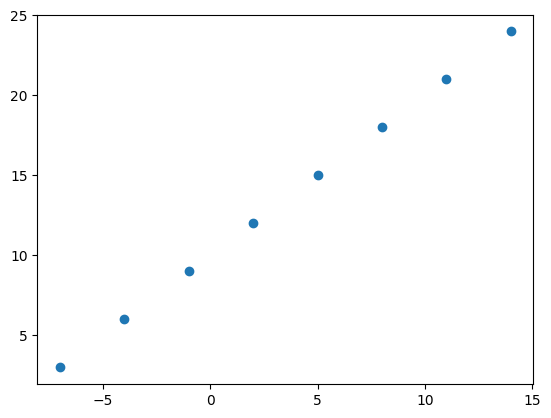

In [2]:
import numpy as np
import matplotlib.pyplot as plt 

# Create features
X = np.array([-7.0, -4.0, -1.0, 2.0, 5.0, 8.0, 11.0, 14.0])

# Create labels
y = np.array([3.0, 6.0, 9.0, 12.0, 15.0, 18.0, 21.0, 24.0])

# Visualize it
plt.scatter(X, y)

In [3]:
y == X +10

array([ True,  True,  True,  True,  True,  True,  True,  True])

## Input and output shapes

In [4]:
# Create a demo tensor for a housing price prediction problem
house_info = tf.constant(["bedroom", "bathroom", "garage"])
house_price = tf.constant([939700])
house_info, house_price

(<tf.Tensor: shape=(3,), dtype=string, numpy=array([b'bedroom', b'bathroom', b'garage'], dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([939700], dtype=int32)>)

In [5]:
X[0], y[0]

(-7.0, 3.0)

In [6]:
input_shape = X[0].shape
output_shape = y[0].shape
input_shape, output_shape

((), ())

In [7]:
X[0].ndim

0

In [8]:
# Turn our NumPy array into Tensors with dtype float32
X = tf.cast(tf.constant(X), dtype=tf.float32)
y = tf.cast(tf.constant(y), dtype=tf.float32)
X, y

(<tf.Tensor: shape=(8,), dtype=float32, numpy=array([-7., -4., -1.,  2.,  5.,  8., 11., 14.], dtype=float32)>,
 <tf.Tensor: shape=(8,), dtype=float32, numpy=array([ 3.,  6.,  9., 12., 15., 18., 21., 24.], dtype=float32)>)

In [9]:
input_shape = X[0].shape
out_shape = y[0].shape
input_shape, out_shape

(TensorShape([]), TensorShape([]))

## Steps in modelling with TensorFlow

Now we know what data we have as well as the input and output shapes, let's see how we'd build a neural network to model it.

In TensorFlow, there are typically 3 fundamental steps to creating and training a model.

1. **Creating a model** - Define the input and output layes, as well as the hidden layers of a deep learning model. piece together the layers of a neural network yourself (using the [Functional](https://www.tensorflow.org/guide/keras/functional) or [Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)) or import a previously built model (known as transfer learning).
2. **Compiling a model** - defining how a models performance should be measured (**loss**(the function which tells our model how wrong it is)/**metrics**(what we can use to interpret the performance of our model)) as well as defining how it should improve (**optimizer**(tell our model how to improve the patterns its learning)). 
3. **Fitting a model** - letting the model try to find patterns in the data (how does `X` get to `y`). 

Let's see these in action using the [Keras Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) to build a model for our regression data. And then we'll step through each.

> **Note:** If you're using [TensorFlow 2.7.0](https://github.com/tensorflow/tensorflow/releases/tag/v2.7.0)+, the `fit()` function no longer upscales input data to go from `(batch_size, )` to `(batch_size, 1)`. To fix this, you'll need to expand the dimension of input data using `tf.expand_dims(input_data, axis=-1)`.
>
> In our case, this means instead of using `model.fit(X, y, epochs=5)`, use `model.fit(tf.expand_dims(X, axis=-1), y, epochs=5)`. 

In [10]:
# Set random seed
tf.random.set_seed(42)

# 1- Create a model using the sequential API
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])

# 2- Compile the model
model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["mae"])

# model.fit(X, y, epochs=5) # this will break with TensorFlow 2.7.0+
model.fit(tf.expand_dims(X, axis=-1), y, epochs=5)

Epoch 1/5
1/1 [==============================] - 4s 4s/step - loss: 8.5848 - mae: 8.5848
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 8.4523 - mae: 8.4523
Epoch 3/5
1/1 [==============================] - 0s 10ms/step - loss: 8.3198 - mae: 8.3198
Epoch 4/5
1/1 [==============================] - 0s 9ms/step - loss: 8.1873 - mae: 8.1873
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 8.0548 - mae: 8.0548


**epochs-- how many times the model will go through all of the training examples**

In [11]:
# Check out X and  y
X, y

(<tf.Tensor: shape=(8,), dtype=float32, numpy=array([-7., -4., -1.,  2.,  5.,  8., 11., 14.], dtype=float32)>,
 <tf.Tensor: shape=(8,), dtype=float32, numpy=array([ 3.,  6.,  9., 12., 15., 18., 21., 24.], dtype=float32)>)

In [12]:
# Try and make a prediction using our model
y_pred = model.predict([17.0])
y_pred

1/1 [==============================] - 0s 83ms/step


array([[26.898891]], dtype=float32)

## Improving a model

How do you think you'd improve upon our current model?

If you guessed by tweaking some of the things we did above, you'd be correct.

To improve our model, we alter almost every part of the 3 steps we went through before.

1. **Creating a model**:

  1-1- here you might want to add more layers, 

  1-2- increase the number of hidden units (also called neurons) within each layer, 

  1-3- change the activation functions of each layer.
2. **Compiling a model**:

 2-1- you might want to choose optimization function 

 2-2- perhaps change the **learning rate** of the optimization function.
3. **Fitting a model**:

 3-1- perhaps you could fit a model for more **epochs** (leave it training for longer) 
 
  3-2- or on more data (give the model more examples to learn from).

![various options you can use to improve a neural network model](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-improving-a-model-from-model-perspective.png)
*There are many different ways to potentially improve a neural network. Some of the most common include: increasing the number of layers (making the network deeper), increasing the number of hidden units (making the network wider) and changing the learning rate. Because these values are all human-changeable, they're referred to as [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)) and the practice of trying to find the best hyperparameters is referred to as [hyperparameter tuning](https://en.wikipedia.org/wiki/Hyperparameter_optimization).*

Woah. We just introduced a bunch of possible steps. The important thing to remember is how you alter each of these will depend on the problem you're working on.

And the good thing is, over the next few problems, we'll get hands-on with all of them.

For now, let's keep it simple, all we'll do is train our model for longer (everything else will stay the same).

In [13]:
# Let's rebuild our model

# 1. Create the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["mae"])

# 3. Fit the model
model.fit(tf.expand_dims(X, axis=-1), y, epochs=100)

Epoch 1/100
1/1 [==============================] - 0s 336ms/step - loss: 20.8692 - mae: 20.8692
Epoch 2/100
1/1 [==============================] - 0s 10ms/step - loss: 20.4983 - mae: 20.4983
Epoch 3/100
1/1 [==============================] - 0s 9ms/step - loss: 20.2170 - mae: 20.2170
Epoch 4/100
1/1 [==============================] - 0s 9ms/step - loss: 19.9358 - mae: 19.9358
Epoch 5/100
1/1 [==============================] - 0s 10ms/step - loss: 19.6545 - mae: 19.6545
Epoch 6/100
1/1 [==============================] - 0s 10ms/step - loss: 19.3733 - mae: 19.3733
Epoch 7/100
1/1 [==============================] - 0s 11ms/step - loss: 19.0920 - mae: 19.0920
Epoch 8/100
1/1 [==============================] - 0s 10ms/step - loss: 18.8108 - mae: 18.8108
Epoch 9/100
1/1 [==============================] - 0s 11ms/step - loss: 18.5295 - mae: 18.5295
Epoch 10/100
1/1 [==============================] - 0s 10ms/step - loss: 18.2483 - mae: 18.2483
Epoch 11/100
1/1 [==============================] 

In [14]:
# Remind ourselves of the data
X, y

(<tf.Tensor: shape=(8,), dtype=float32, numpy=array([-7., -4., -1.,  2.,  5.,  8., 11., 14.], dtype=float32)>,
 <tf.Tensor: shape=(8,), dtype=float32, numpy=array([ 3.,  6.,  9., 12., 15., 18., 21., 24.], dtype=float32)>)

In [15]:
y_pred = model.predict([17.0])
y_pred

1/1 [==============================] - 0s 61ms/step


array([[29.640709]], dtype=float32)

In [16]:
from keras import optimizers
# Let's see if we can make another to improve model

# 1. Create the model ()
model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation=None),
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=["mae"])

# 3. Fit the model
model.fit(tf.expand_dims(X, axis=-1), y, epochs=100)

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 12.9336 - mae: 12.9336
Epoch 2/100
1/1 [==============================] - 0s 9ms/step - loss: 12.2386 - mae: 12.2386
Epoch 3/100
1/1 [==============================] - 0s 9ms/step - loss: 11.5409 - mae: 11.5409
Epoch 4/100
1/1 [==============================] - 0s 12ms/step - loss: 10.8371 - mae: 10.8371
Epoch 5/100
1/1 [==============================] - 0s 11ms/step - loss: 10.1237 - mae: 10.1237
Epoch 6/100
1/1 [==============================] - 0s 9ms/step - loss: 9.3984 - mae: 9.3984
Epoch 7/100
1/1 [==============================] - 0s 10ms/step - loss: 8.6589 - mae: 8.6589
Epoch 8/100
1/1 [==============================] - 0s 10ms/step - loss: 7.9026 - mae: 7.9026
Epoch 9/100
1/1 [==============================] - 0s 10ms/step - loss: 7.1270 - mae: 7.1270
Epoch 10/100
1/1 [==============================] - 0s 10ms/step - loss: 6.7929 - mae: 6.7929
Epoch 11/100
1/1 [==============================] - 0s 12ms/step

In [20]:
y_pred = model.predict([17.0])
y_pred

1/1 [==============================] - 0s 35ms/step


array([[26.938065]], dtype=float32)

## Evaluating a model 

A typical workflow you'll go through when building neural networks is:

```
Build a model -> evaluate it -> build (tweak) a model -> evaulate it -> build (tweak) a model -> evaluate it...
```

The tweaking comes from maybe not building a model from scratch but adjusting an existing one.

### Visualize, visualize, visualize

When it comes to evaluation, you'll want to remember the words: "visualize, visualize, visualize." 

This is because you're probably better looking at something (doing) than you are thinking about something.

It's a good idea to visualize:
* **The data** - what data are you working with? What does it look like?
* **The model itself** - what does the architecture look like? What are the different shapes?
* **The training of a model** - how does a model perform while it learns?
* **The predictions of a model** - how do the predictions of a model line up against the ground truth (the original labels)?

Let's start by visualizing the model.

But first, we'll create a little bit of a bigger dataset and a new model we can use (it'll be the same as before, but the more practice the better).


In [22]:
# Make a bigger data
X = tf.range(-100, 100, 4)
X

<tf.Tensor: shape=(50,), dtype=int32, numpy=
array([-100,  -96,  -92,  -88,  -84,  -80,  -76,  -72,  -68,  -64,  -60,
        -56,  -52,  -48,  -44,  -40,  -36,  -32,  -28,  -24,  -20,  -16,
        -12,   -8,   -4,    0,    4,    8,   12,   16,   20,   24,   28,
         32,   36,   40,   44,   48,   52,   56,   60,   64,   68,   72,
         76,   80,   84,   88,   92,   96], dtype=int32)>

In [23]:
# Make labels for the dataset
y = X + 10
y

<tf.Tensor: shape=(50,), dtype=int32, numpy=
array([-90, -86, -82, -78, -74, -70, -66, -62, -58, -54, -50, -46, -42,
       -38, -34, -30, -26, -22, -18, -14, -10,  -6,  -2,   2,   6,  10,
        14,  18,  22,  26,  30,  34,  38,  42,  46,  50,  54,  58,  62,
        66,  70,  74,  78,  82,  86,  90,  94,  98, 102, 106], dtype=int32)>

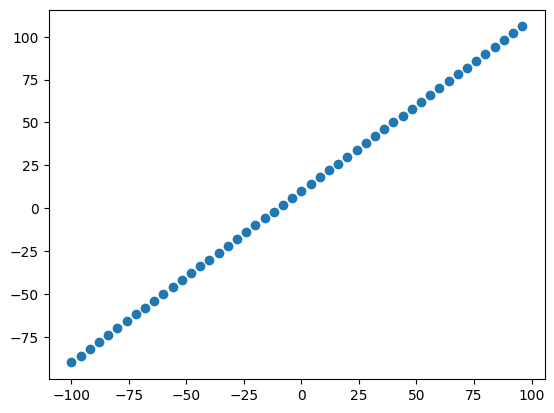

In [24]:
# Visualize the data
import matplotlib.pyplot as plt
plt.scatter(X, y)

## Split data into training/test set

One of the other most common and important steps in a machine learning project is creating a training and test set (and when required, a validation set).

Each set serves a specific purpose:
* **Training set** - the model learns from this data, which is typically 70-80% of the total data available (like the course materials you study during the semester).
* **Validation set** - the model gets tuned on this data, which is typically 10-15% of the total data available (like the practice exam you take before the final exam).
* **Test set** - the model gets evaluated on this data to test what it has learned, it's typically 10-15% of the total data available (like the final exam you take at the end of the semester).

For now, we'll just use a training and test set, this means we'll have a dataset for our model to learn on as well as be evaluated on.

We can create them by splitting our `X` and `y` arrays.

> 🔑 **Note:** When dealing with real-world data, this step is typically done right at the start of a project (the test set should always be kept separate from all other data). We want our model to learn on training data and then evaluate it on test data to get an indication of how well it **generalizes** to unseen examples.

In [25]:
# Check how many samples we have
len(X)

50

In [26]:
# Split the data into train and test sets
X_train = X[:40] # first 40 are trainingsamples (80% of the data)
y_train = y[:40]

X_test = X[40:] # Last 10 are testing samples (20% of the data)
y_test = y[40:]

len(X_train), len(X_test), len(y_train), len(y_test)

(40, 10, 40, 10)

## Visualizing the data

Now we've got our training and test data, it's a good idea to visualize it.

Let's plot it with some nice colours to differentiate what's what.

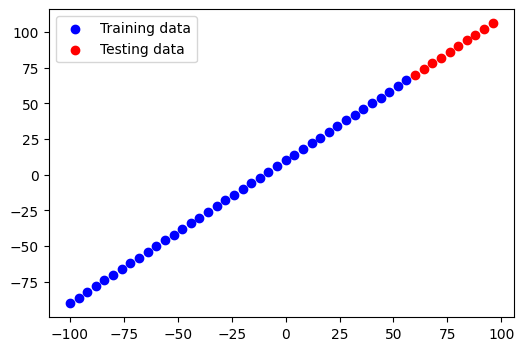

In [31]:
plt.figure(figsize=(6, 4))
# Plot training data in blue
plt.scatter(X_train, y_train, c="b", label="Training data")
# Plot testing data in red
plt.scatter(X_test, y_test, c="r", label="Testing data")
plt.legend();

Beautiful! Any time you can visualize your data, your model, your anything, it's a good idea. 

With this graph in mind, what we'll be trying to do is build a model which learns the pattern in the blue dots (`X_train`) to draw the green dots (`X_test`).

Time to build a model. We'll make the exact same one from before (the one we trained for longer).

In [33]:
# Let's have a look at how to build a neural network for our data

# 1. Create a model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["mae"])

# # 3. Fit the model
# model.fit(X_train, y_train, epochs=100)

## Visualizing the model

After you've built a model, you might want to take a look at it (especially if you haven't built many before).

You can take a look at the layers and shapes of your model by calling [`summary()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#summary) on it.

> 🔑 **Note:** Visualizing a model is particularly helpful when you run into input and output shape mismatches.

In [38]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


Ahh, the cell above errors because we haven't fit our built our model.

We also haven't told it what input shape it should be expecting.

Remember above, how we discussed the input shape was just one number?

We can let our model know the input shape of our data using the `input_shape` parameter to the first layer (usually if `input_shape` isn't defined, Keras tries to figure it out automatically).

In [61]:
# Let's create a model which builds automatically by defining the input shape atgument
tf.random.set_seed(42)

# 1. Create a model (same as above)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, input_shape=[1], name="input_layer"),
    tf.keras.layers.Dense(1, name="output_layer")
], name="model_1")

# 2. Compile the model
model.compile(loss=tf.keras.losses.mae,
             optimizer=tf.keras.optimizers.SGD(),
             metrics=["mae"])

In [62]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (Dense)         (None, 10)                20        
                                                                 
 output_layer (Dense)        (None, 1)                 11        
                                                                 
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


Calling `summary()` on our model shows us the layers it contains, the output shape and the number of parameters.
* **Total params** - total number of parameters in the model.
* **Trainable parameters** - these are the parameters (patterns) the model can update as it trains.
* **Non-trainable parameters** - these parameters aren't updated during training (this is typical when you bring in the already learned patterns from other models during transfer learning).

> 📖 **Resource:** For a more in-depth overview of the trainable parameters within a layer, check out [MIT's introduction to deep learning video](https://youtu.be/njKP3FqW3Sk).

> 🛠 **Exercise:** Try playing around with the number of hidden units in the `Dense` layer (e.g. `Dense(2)`, `Dense(3)`). How does this change the Total/Trainable params? Investigate what's causing the change.

For now, all you need to think about these parameters is that their learnable patterns in the data.

Let's fit our model to the training data.

In [63]:
# Let's fit the model to the training data

# 3. Fit the model
model.fit(X_train, y_train, epochs=100, verbose=0)

In [64]:
# Get a summary of our model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (Dense)         (None, 10)                20        
                                                                 
 output_layer (Dense)        (None, 1)                 11        
                                                                 
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


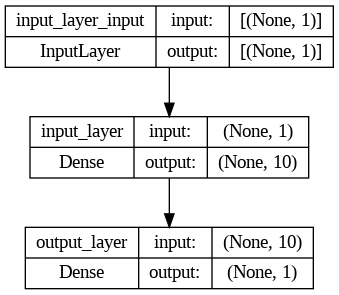

In [65]:
from tensorflow.keras.utils import plot_model

plot_model(model=model, show_shapes=True)

## Visualizing the predictions

Now we've got a trained model, let's visualize some predictions.

To visualize predictions, it's always a good idea to plot them against the ground truth labels.

Often you'll see this in the form of `y_test` vs. `y_pred` (ground truth vs. predictions).

First, we'll make some predictions on the test data (`X_test`), remember the model has never seen the test data.